Project created by : Sakshi Jadhav

# **Diabetic Patients’ Readmission Prediction**


**Objective:**

*   Develop a binary classification model to predict whether a diabetic patient will be readmitted to the hospital within 30 days of discharge.

# **Exploring and sanitizing the data**


**Loading the data**

In [ ]:
import pandas as pd
# diabetic_data.csv contains information about patient hospitalizations and readmission.
diabetic_data_file = 'diabetic_data.csv'
ids_file = 'IDS_mapping.csv'
diabetic_data = pd.read_csv(diabetic_data_file)
ids_mapping = pd.read_csv(ids_file)

**Initial Data Exploration**

In [ ]:
# Understanding structure, data types, and missing values
print("Initial Structure of the Dataset")
print(diabetic_data.info())

Initial Structure of the Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            

**Inspecting Data**

In [ ]:
# Previewing initial rows
print("\nFirst Few Rows of Data:")
print(diabetic_data.head())


First Few Rows of Data:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No    

**Handling Missing Values**

In [ ]:
# Identifying missing values encoded as '?' or 'Unknown'
missing_values = diabetic_data.isin(['?', 'Unknown', None]).sum()
print("\nMissing Values in Each Column:")
 # Displaying columns with missing values
print(missing_values[missing_values > 0])


Missing Values in Each Column:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64


In [ ]:
# Converting 'readmitted' to a binary target variable for early readmission classification
target_distribution = diabetic_data['readmitted'].value_counts()
print("\nTarget Variable (readmitted) Distribution:")
print(target_distribution)


Target Variable (readmitted) Distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


**Observations:**


*   Target variable is imbalanced with '<30' (early readmission) being less frequent.
*   Few columns like weight, payer_code, medical_specialty have significant missing values.

# **Data Cleaning and Preprocessing**

In [ ]:
# Droping irrelevant columns which likely do not contribute much to predicting readmission.
diabetic_cleaned = diabetic_data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [ ]:
# Converting the target variable to binary: 1 for '<30' (readmitted within 30 days), 0 otherwise.
diabetic_cleaned['readmitted'] = diabetic_cleaned['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [ ]:
# One-hot encoding categorical columns to create dummy variables
categorical_features = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult']
diabetic_data_encoded = pd.get_dummies(diabetic_cleaned, columns=categorical_features, drop_first=True)

In [ ]:
# Label encoding 'diag_1', 'diag_2', and 'diag_3' as they are categorical but contain many unique values
from sklearn.preprocessing import LabelEncoder
for col in ['diag_1', 'diag_2', 'diag_3']:
    labEn = LabelEncoder()
    diabetic_data_encoded[col] = labEn.fit_transform(diabetic_data_encoded[col])

In [ ]:
# Identifying and encoding binary categorical columns
binary_columns = [col for col in diabetic_data_encoded.columns if diabetic_data_encoded[col].dtype == 'object']

for col in binary_columns:
    labEn = LabelEncoder()
    diabetic_data_encoded[col] = labEn.fit_transform(diabetic_data_encoded[col])

print("\n Encoded Data Sample:")
print(diabetic_data_encoded.head())


 Encoded Data Sample:
   encounter_id  patient_nbr  admission_type_id  discharge_disposition_id  \
0       2278392      8222157                  6                        25   
1        149190     55629189                  1                         1   
2         64410     86047875                  1                         1   
3        500364     82442376                  1                         1   
4         16680     42519267                  1                         1   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                    1                 1                  41               0   
1                    7                 3                  59               0   
2                    7                 2                  11               5   
3                    7                 2                  44               1   
4                    7                 1                  51               0   

   num_medications  number_outpat

**Observations:**


*   The dataset is now numeric and ready for machine learning models.
*   Binary target variable enables use of binary classification models.


# **Exploratory Data Analysis (EDA)**

Text(0.5, 1.0, 'Distribution of Time in Hospital')

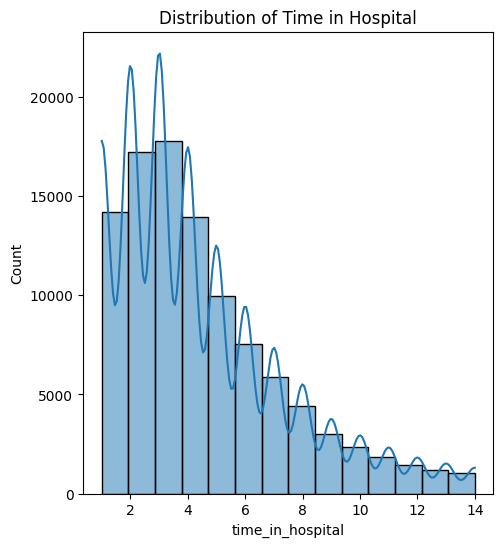

In [ ]:
# Univariate Analysis - Distributions of selected features
# Plot distribution of time in hospital
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(diabetic_data_encoded['time_in_hospital'], bins=14, kde=True)
plt.title('Distribution of Time in Hospital')

Text(0.5, 1.0, 'Distribution of Number of Lab Procedures')

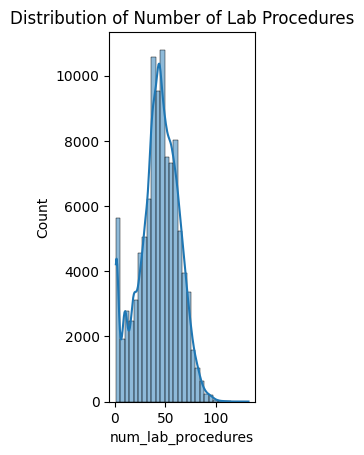

In [ ]:
# Plot distribution of number of lab procedure
plt.subplot(1, 3, 2)
sns.histplot(diabetic_data_encoded['num_lab_procedures'], bins=30, kde=True)
plt.title('Distribution of Number of Lab Procedures')

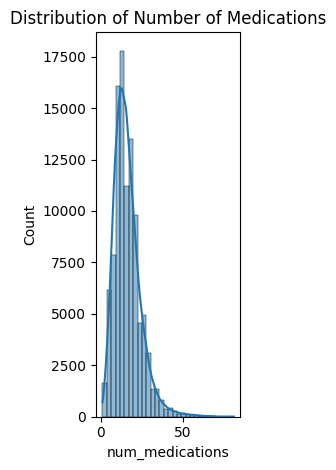

In [ ]:
# Plot distribution of number of medications
plt.subplot(1, 3, 3)
sns.histplot(diabetic_data_encoded['num_medications'], bins=30, kde=True)
plt.title('Distribution of Number of Medications')
plt.tight_layout()
plt.show()

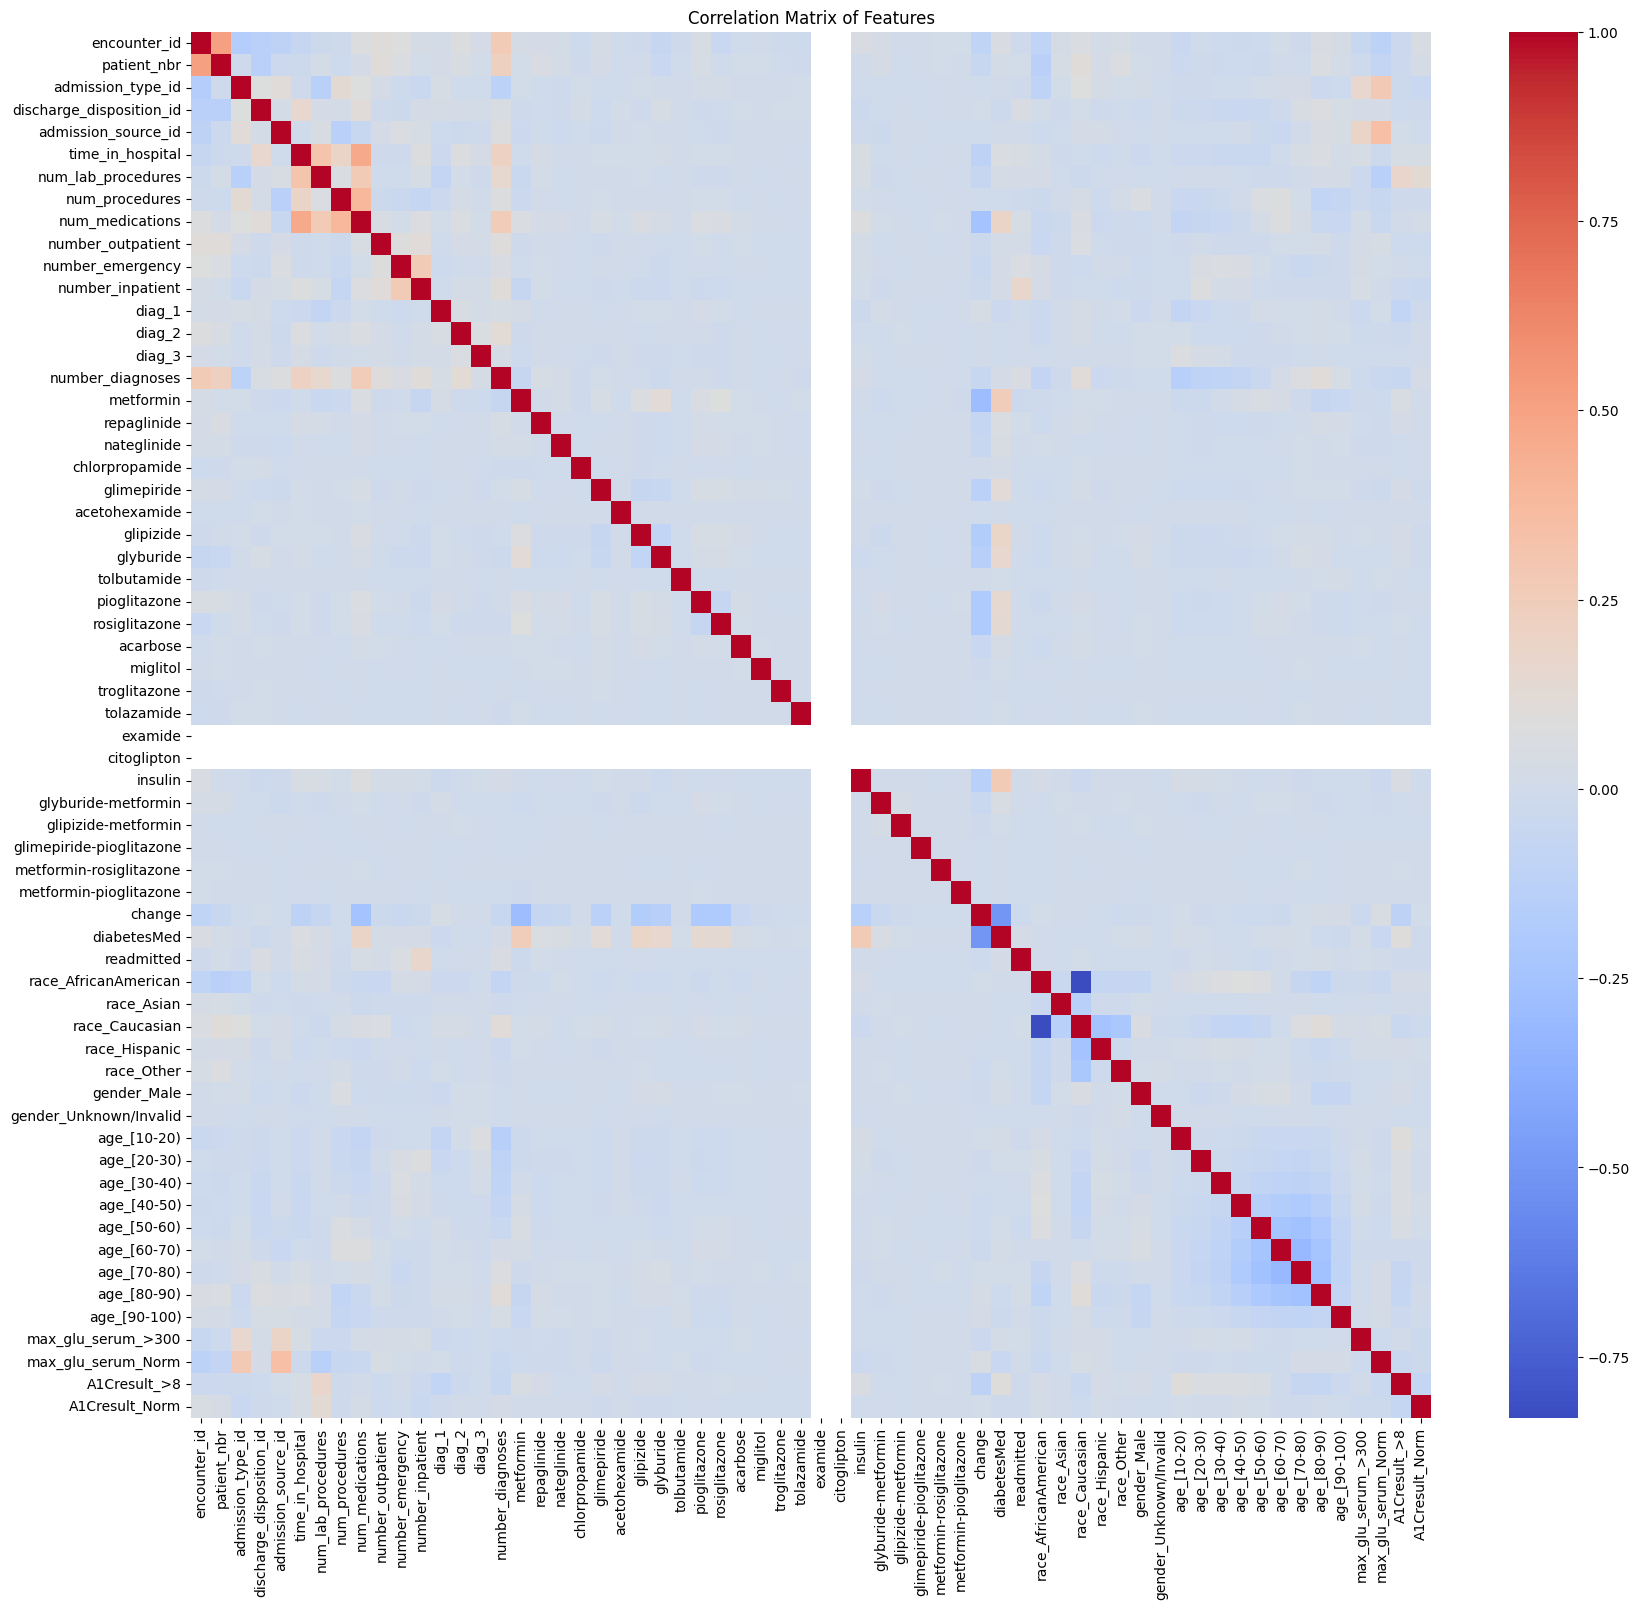

In [ ]:
# Bivariate Analysis - Correlation Matrix
# Correlation analysis to identify relationships between features and target
correlation_matrix = diabetic_data_encoded.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# Identify features most correlated with the target variable
correlations_with_target = correlation_matrix['readmitted'].sort_values(ascending=False)
print("\nTop Correlated Features with Target Variable:")
print(correlations_with_target.head(10))


Top Correlated Features with Target Variable:
readmitted                  1.000000
number_inpatient            0.165147
number_emergency            0.060747
discharge_disposition_id    0.050560
number_diagnoses            0.049524
time_in_hospital            0.044199
num_medications             0.038432
diabetesMed                 0.027125
num_lab_procedures          0.020364
number_outpatient           0.018893
Name: readmitted, dtype: float64


# **Feature Selection**

In [ ]:
# Separate features (X) and target (y) for modeling
X = diabetic_data_encoded.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])
y = diabetic_data_encoded['readmitted']


*   I initially experimented with using SMOTE to address class imbalance in the dataset, aiming to improve the predictive performance of the models. However, despite the balanced class distribution achieved by SMOTE, the models trained on the oversampled data showed a decrease in overall accuracy. Given this outcome, I decided to remove SMOTE from the preprocessing steps and continued with the original dataset to maintain higher accuracy in the model predictions."

In [ ]:
# Fitting Random Forest for feature importance
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
# Top 10 features by importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.head(10)
print("\nTop Features by Random Forest Importance:")
print(top_features)


Top Features by Random Forest Importance:
num_lab_procedures          0.093609
diag_2                      0.091195
diag_1                      0.090999
diag_3                      0.089249
num_medications             0.080318
time_in_hospital            0.056848
number_inpatient            0.044057
num_procedures              0.039469
discharge_disposition_id    0.038109
number_diagnoses            0.036605
dtype: float64


# **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Stratified spliting to maintain target distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("\nTraining Set Class Distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest Set Class Distribution:")
print(y_test.value_counts(normalize=True))


Training Set Class Distribution:
readmitted
0    0.888395
1    0.111605
Name: proportion, dtype: float64

Test Set Class Distribution:
readmitted
0    0.888425
1    0.111575
Name: proportion, dtype: float64


In [ ]:
# Scaling the features for SVM
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Building**

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay
)

# Initializing Logistic Regression model
logistic_model = LogisticRegression()

# Training the model on scaled data
logistic_model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = logistic_model.predict(X_test_scaled)
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy:}")
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")
print(f"F1 Score: {f1:f}")
print(f"ROC AUC: {roc_auc:}")

print(classification_report(y_test, y_pred))

Logistic Regression Results:
Accuracy: 0.8884248796305394
Precision: 0.5
Recall: 0.013650374284456186
F1 Score: 0.026575
ROC AUC: 0.645071518524847
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.50      0.01      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.69      0.51      0.48     20354
weighted avg       0.85      0.89      0.84     20354



 I applied hyperparameter tuning to all models except for logistic regression. I initially attempted to incorporate hyperparameter tuning into the logistic regression model as well. However, due to the significant amount of time it took to execute, which impeded efficient progress, I decided to proceed without tuning the hyperparameters for logistic regression.

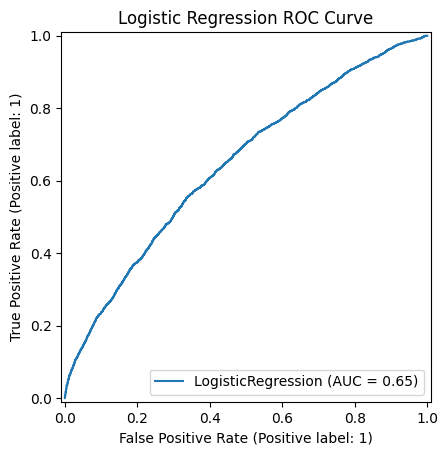

In [ ]:
RocCurveDisplay.from_estimator(logistic_model, X_test_scaled, y_test)
plt.title("Logistic Regression ROC Curve")
plt.show()

**Decision Tree**

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 10}
Decision Tree Results:
Accuracy: 0.8886214011987815
Precision: 0.5303030303030303
Recall: 0.015411712901805373
F1 Score: 0.02995293110825845
ROC AUC: 0.659273291245006
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.53      0.02      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.71      0.51      0.49     20354
weighted avg       0.85      0.89      0.84     20354



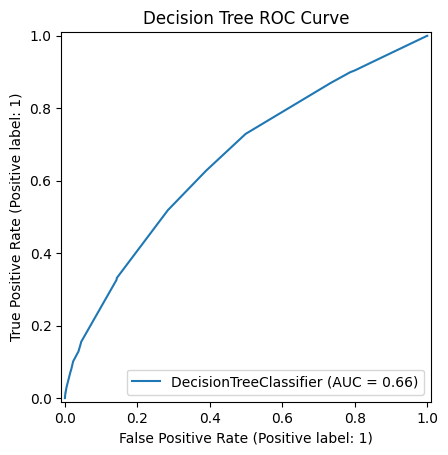

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree Setup
tree_model = DecisionTreeClassifier(random_state=42)

# hyperparameters to balance model complexity and generalizability.
param_grid_tree = {"max_depth": [5, 10, 15, 20],  # Smaller depths to reduce overfitting
                   "min_samples_split": [2, 5, 10]} # Larger values ensure more data per split, improving generalization
grid_tree = GridSearchCV(tree_model, param_grid_tree, cv=5, scoring='roc_auc', verbose=1)

# Fiting the model
grid_tree.fit(X_train, y_train)

# Using GridSearchCV to find the best hyperparameter combination
best_tree = grid_tree.best_estimator_
print("Best Parameters for Decision Tree:", grid_tree.best_params_)

# Evaluating the best model
y_pred = best_tree.predict(X_test)
y_pred_proba = best_tree.predict_proba(X_test)[:, 1]

print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

print(classification_report(y_test, y_pred))


# Ploting ROC curve
RocCurveDisplay.from_estimator(best_tree, X_test, y_test)
plt.title("Decision Tree ROC Curve")
plt.show()

Observations for decision tree

1. GridSearchCV was used to systematically tune hyperparameters, which improved the model's ROC AUC score.
2. ROC AUC was chosen as the evaluation metric to handle the imbalance in the dataset.
3. The max_depth and min_samples_split hyperparameters were optimized to balance the model's ability to fit training data while generalizing well to unseen data.
4. Results: High accuracy (0.889) but poor recall (0.015) for <30 Days.








**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Implementing Random Forest because it is an ensemble method combining multiple decision trees, which reduces overfitting and improves generalization by averaging predictions from multiple trees
# Initializing the Random Forest Model
forest_model = RandomForestClassifier(random_state=42)
param_grid_forest = {
    "n_estimators": [10, 50],
    "max_depth": [5, 10]
}

In [ ]:
# Performing Grid Search with 3-fold cross-validation to identify the best combination of hyperparameters.
grid_forest = GridSearchCV(forest_model, param_grid_forest, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
# scoring='roc_auc': Using ROC AUC as the scoring metric to handle class imbalance.
# n_jobs=-1: Utilizes all available cores to speed up training.

# Training the Random Forest model using the training data.
grid_forest.fit(X_train, y_train)

# Best model from Grid Search
best_forest = grid_forest.best_estimator_
print("Best Parameters for Random Forest:", grid_forest.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}


In [ ]:
# Evaluating the best model
y_pred = best_forest.predict(X_test)
y_pred_proba = best_forest.predict_proba(X_test)[:, 1]
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

Random Forest Results:
Accuracy: 0.8884248796305394
Precision: 0.5
Recall: 0.00044033465433729633
F1 Score: 0.0008798944126704796
ROC AUC: 0.662114390922059
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.50      0.00      0.00      2271

    accuracy                           0.89     20354
   macro avg       0.69      0.50      0.47     20354
weighted avg       0.85      0.89      0.84     20354



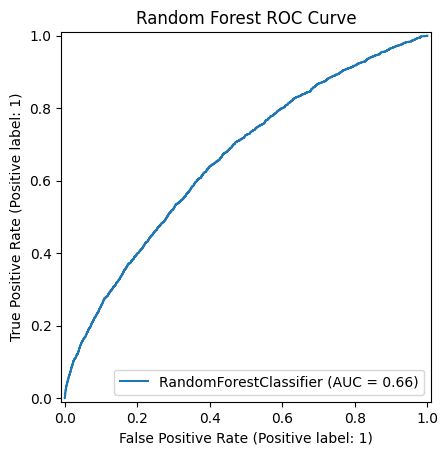

In [ ]:
# Ploting Random Forest ROC curve
RocCurveDisplay.from_estimator(best_forest, X_test, y_test)
plt.title("Random Forest ROC Curve")
plt.show()


**XGBoost**

In [ ]:
from xgboost import XGBClassifier
# Cleaning column names to ensure compatibility with XGBoost.
X_train.columns = [str(col).replace("[", "").replace("]", "").replace("<", "").replace(">", "") for col in X_train.columns]
X_test.columns = [str(col).replace("[", "").replace("]", "").replace("<", "").replace(">", "") for col in X_test.columns]
# Setting up XGBoost with default parameters:
# eval_metric='logloss': Logarithmic loss as the evaluation metric.
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)  # Removed use_label_encoder

# Training  the model using the training dataset.
xgb_model.fit(X_train, y_train)

# Predictions on the test set.
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class.

# evaluation metrics.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [ ]:
#  metric values
print("XGBoost Results:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

XGBoost Results:
Accuracy: 0.89
Precision: 0.43
Recall: 0.03
F1 Score: 0.05
ROC AUC: 0.67


In [ ]:
#  metric values
print("XGBoost Results:")
print(f"Accuracy: {accuracy:}")
print(f"ROC AUC: {roc_auc:}")
#classification report for each class.
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

XGBoost Results:
Accuracy: 0.8874914021813894
ROC AUC: 0.6730480735231031

Classification Report:
              precision    recall  f1-score   support

           0     0.8906    0.9957    0.9402     18083
           1     0.4307    0.0260    0.0490      2271

    accuracy                         0.8875     20354
   macro avg     0.6606    0.5108    0.4946     20354
weighted avg     0.8393    0.8875    0.8408     20354



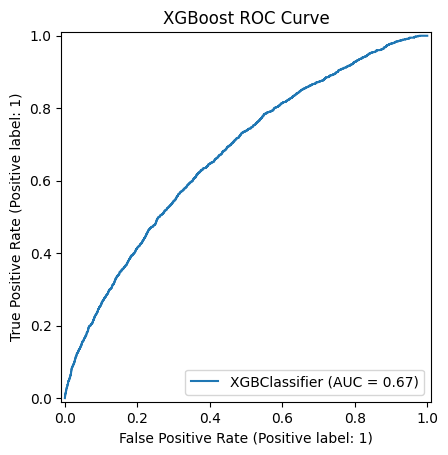

In [ ]:
# Ploting ROC curve for XGBoost
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("XGBoost ROC Curve")
plt.show()


# **Model Evaluation**

In [ ]:
# Function to select the best model
def select_best_model(models, X_test, y_test):
    best_score = 0
    best_model_name = None
    for name, model in models.items():
        probabilities = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        if roc_auc > best_score:
            best_score = roc_auc
            best_model_name = name
    return best_model_name, best_score

In [ ]:
# Creating dictionary containing model objects
models = {
    'Logistic Regression': logistic_model,
    'Decision Tree': best_tree,
    'Random Forest': best_forest,
    'XGBoost': xgb_model
}

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Ensuring X_test matches the feature names of X_train
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

# Ploting Confusion Matrix for the Best Model
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Getting predictions
    y_pred = model.predict(X_test)

    # Generating confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


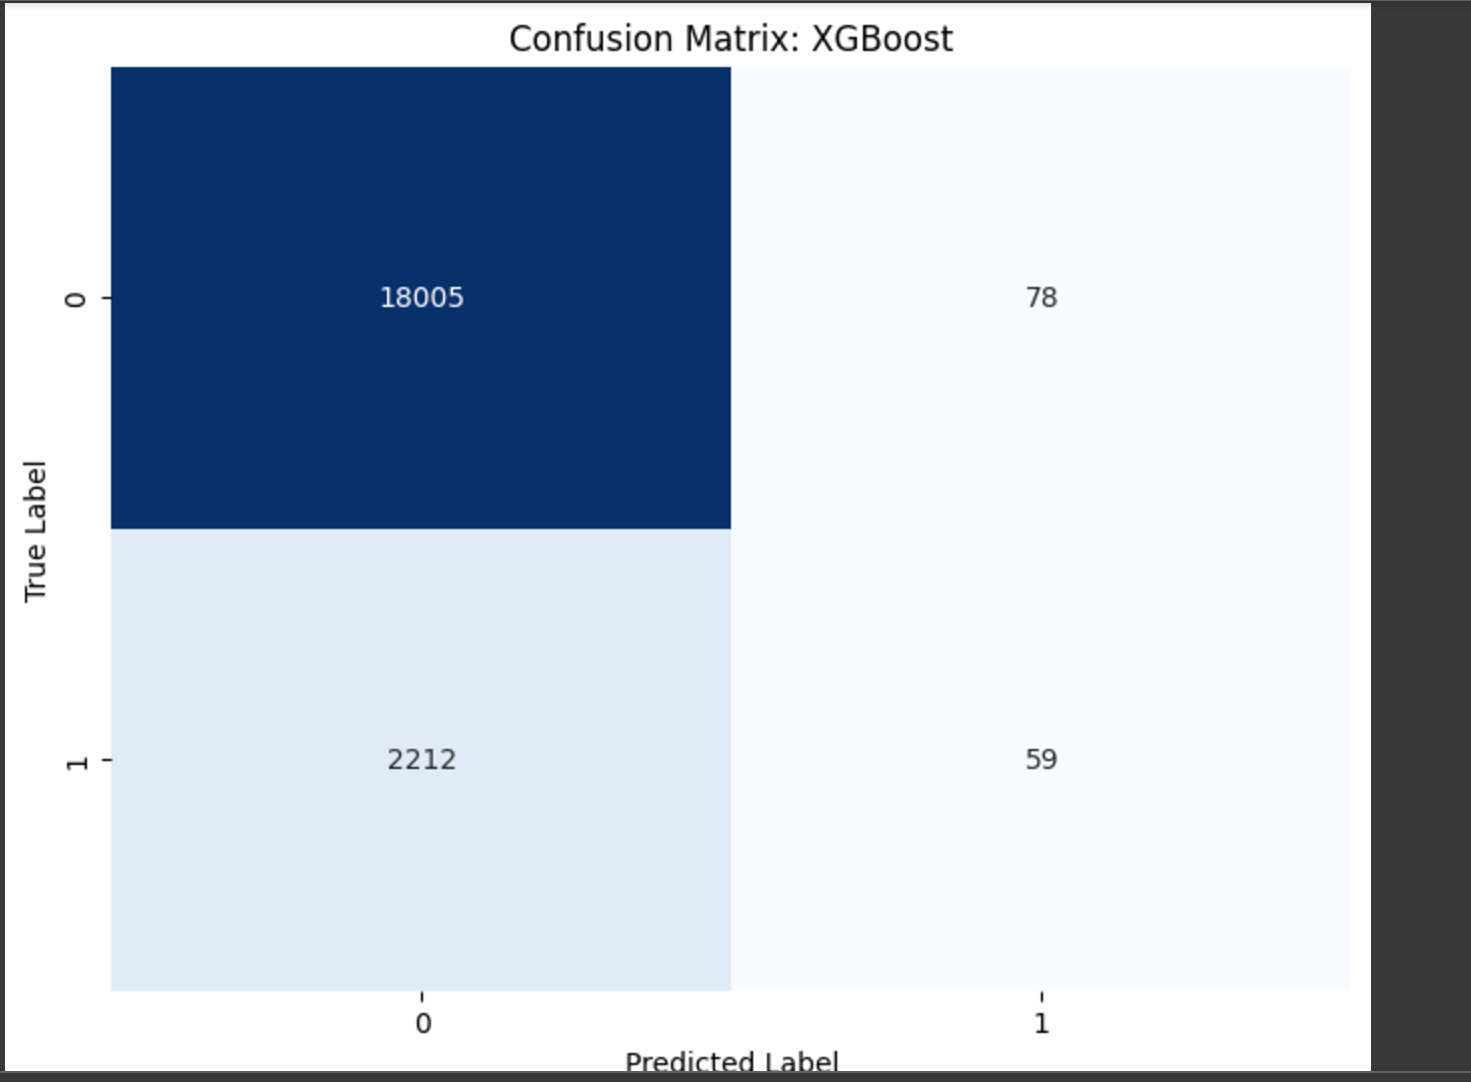

# **FINDINGS**

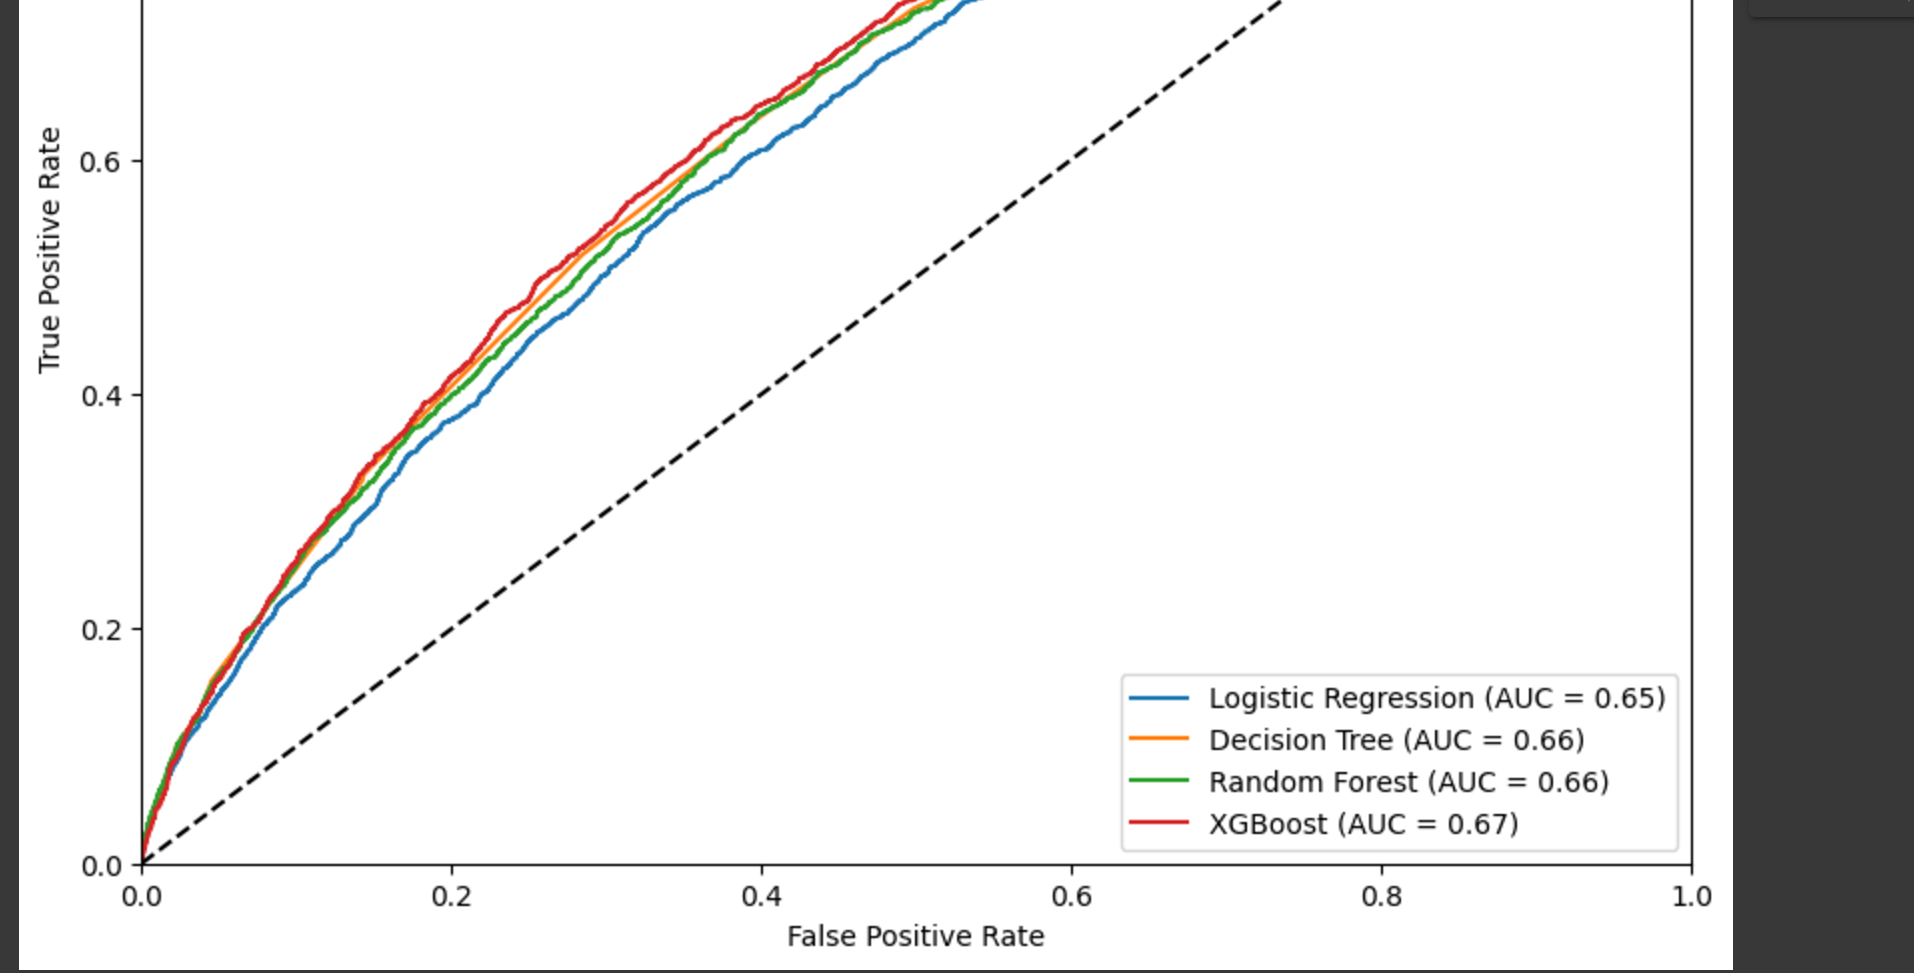

**Analysis of Models:**

*   Logistic Regression (AUC = 0.65): This model has the lowest AUC among the four, showing relatively poor performance in distinguishing between classes.

*   Decision Tree (AUC = 0.66): Slight improvement over Logistic Regression, likely due to capturing some non-linear relationships.

*   Random Forest (AUC = 0.66): Comparable performance to the Decision Tree, but as an ensemble model, it may overfit less.


*   XGBoost (AUC = 0.67): Shows the best performance with the highest AUC score.

**Conclusion**


*   Best Model : XGBoost


*    XGBoost's ROC curve is marginally better, suggesting it is more effective at distinguishing between positive and negative classes.

